In [1]:
import Pkg; 
Pkg.activate(mktempdir())
#Pkg.add("NonlinearSolve")
Pkg.add("StaticArrays")
Pkg.add("Symbolics")
#using NonlinearSolve 
using StaticArrays
using Symbolics

  Activating new project at `/var/folders/yn/m0l92hkn60jb1hk8y126p8vm0000gn/T/jl_iEYrOo`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
    Updating `/private/var/folders/yn/m0l92hkn60jb1hk8y126p8vm0000gn/T/jl_iEYrOo/Project.toml`
  [90137ffa] + StaticArrays v1.4.0
    Updating `/private/var/folders/yn/m0l92hkn60jb1hk8y126p8vm0000gn/T/jl_iEYrOo/Manifest.toml`
  [90137ffa] + StaticArrays v1.4.0
  [56f22d72] + Artifacts
  [8f399da3] + Libdl
  [37e2e46d] + LinearAlgebra
  [9a3f8284] + Random
  [ea8e919c] + SHA
  [9e88b42a] + Serialization
  [2f01184e] + SparseArrays
  [10745b16] + Statistics
  [e66e0078] + CompilerSupportLibraries_jll
  [4536629a] + OpenBLAS_jll
  [8e850b90] + libblastrampoline_jll
   Resolving package versions...
    Updating `/private/var/folders/yn/m0l92hkn60jb1hk8y126p8vm0000gn/T/jl_iEYrOo/Project.toml`
  [0c5d862f] + Symbolics v4.3.0
    Updating `/private/var/folders/yn/m0l92hkn60jb1hk8y126p8vm0000gn/T/jl_iEYrOo/Manifest

Queremos usar Symbolics para hacer las cuentas del Jacobiano y su inversa de manera automática.


Primero definimos una función de $R^N$ en $R^N$, y la tratamos de forma simbólica.

In [4]:
N=2

field = Dict(:ρ => 1, :v => 2) #para acordarse de que campo asignamos a cada componente del vector

@variables u[1:N], v[1:N] #variables para manipulación algebraica
us = Symbolics.scalarize(u)
vs = Symbolics.scalarize(v)

function F(u,v)
    return [u[field[:ρ]] + 0.5 * u[field[:v]]^2 - v[field[:ρ]]; -0.5 * u[field[:ρ]]^2 + u[field[:v]] - v[field[:v]]]
end

F(u,v)
F(rand(2),rand(2))

2-element Vector{Float64}:
  0.6671194430589922
 -0.2531517959896285

Calculamos su jacobiano y su inversa de forma simbólica también. 

In [5]:
    
JS = Symbolics.jacobian(F(us,vs),us)

2×2 Matrix{Num}:
     1  u[2]
 -u[1]     1

In [6]:
JSinv = inv(JS)

2×2 Matrix{Num}:
                    true + (-u[1]*u[2]) / (1 + u[1]*u[2])  …  -(u[2] / (1 + u[1]*u[2]))
 u[1] / (1 + u[1]*u[2])                                                             true / (1 + u[1]*u[2])

In [10]:
Symbolics.simplify(JS*JSinv)

2×2 Matrix{Num}:
                             1                                          …    0
 u[1] / (1 + u[1]*u[2]) - (true + (-u[1]*u[2]) / (1 + u[1]*u[2]))*u[1]     true / (1 + u[1]*u[2]) + (u[2] / (1 + u[1]*u[2]))*u[1]

In [6]:
#JIF(u,p) = f(u,p) * JSinv(u,p)
#JIF(u,p)

Los siguientes pasos son necesarios para promover los jacobianos a funciones normales (no simbólicas) de Julia.

In [11]:
J_exp = Symbolics.build_function(JS, u,v)
Jinv_exp = Symbolics.build_function(JSinv, u,v);
#JIF_exp = Symbolics.build_function(JIF, u,p);

In [12]:
Jac = eval(J_exp[1])
Jac_inv = eval(Jinv_exp[1])
#JacF = eval(JIF_exp[1])

#Jac(SA[2.0,3.0],SA[2])

#5 (generic function with 1 method)

Chequeamos que todo funcione.

In [13]:
Jac([2.0,3.0],[2,3])
Jac_inv([2.0,3.0],[2,3])
Jac_inv([2.0,3.0],[2,3])*Jac([2.0,3.0],[2,3])

2×2 Matrix{Float64}:
 1.0  1.66533e-16
 0.0  1.0

Definimos ahora el paso del Newton Rapson: (si tenemos la inversa de forma explícita ahorramos tiempo (creo) y memoria.

In [14]:
function NR_step!(F, Jac_inv, u0, y)
    u0 - Jac_inv(u0,y) * F(u0,y)
end

function NR_step2!(F, Jac, u0, y)
    u = u0 - Jac.(u0,y) \ F(u0,y)
end

NR_step2! (generic function with 1 method)

Para testear el método elegimos un valor cualquiera de `x` y buscamos el correspondiente `y` de forma que `f(x,y)` se anule. Daremos ese `y` y contastaremos que encontramos el `x` correcto partiendo de un `x0` distinto.

In [15]:
u0 = @SVector[1.0, 3.0]
F(u0,[0,0])
y = @SVector[5.5, 2.5]
F(u0,y)

2-element Vector{Float64}:
 0.0
 0.0

Lo probamos para un valor inicial arbitrario.

In [16]:
u0 = @SVector[2.0, 5.0]
for i ∈ 1:25
    u0 = NR_step!(F, Jac_inv, u0, y)
    #u0 = NR_step!(F, Jac, u0, y)
end
u0
F(u0,y)

2-element Vector{Float64}:
 0.0
 0.0

Ahora vamos a tratar de generalizar al caso donde tenemos un vector de vectores (x,y)

In [17]:
M = 10^3
#u0 = fill(rand(M),N);
#u0 = rand(N,M)
#y = rand(N,M)
#u0 = @SArray[(i+j)/(N+M) for i ∈ 1:N, j ∈ 1:M]
u0 = [(i+j)/(N+M) for i ∈ 1:N, j ∈ 1:M]
println(u0[1,5])
#y = @SArray[1 for i ∈ 1:N, j ∈ 1:M]
y = [1 for i ∈ 1:N, j ∈ 1:M]
y
u0

0.005988023952095809


2×1000 Matrix{Float64}:
 0.00199601  0.00299401  0.00399202  …  0.997006  0.998004  0.999002
 0.00299401  0.00399202  0.00499002     0.998004  0.999002  1.0

No funciona con los @SArray's

In [18]:
tol = 10^(-8)
iter_max = 10

@time begin
for j ∈ 1:M
    iter = 1
    while F(u0[:,j],y[:,j])'*F(u0[:,j],y[:,j]) > tol && iter < iter_max
        u0[:,j] = NR_step!(F, Jac_inv, u0[:,j], y[:,j])
        iter = iter + 1
    end
    #println(iter)
end
end

  0.299936 seconds (863.16 k allocations: 43.358 MiB, 5.67% gc time, 94.00% compilation time)


In [19]:
j = 19
F(u0[:,j],y[:,j])

2-element Vector{Float64}:
  7.915733870600405e-7
 -9.77239132671226e-6

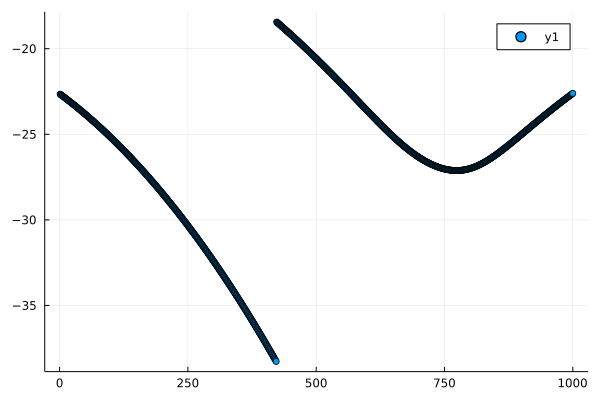

In [20]:
using Plots
ay = zeros(M)
for k ∈ 1:M
    ay[k] =  log(F(u0[:,k],y[:,k])'* F(u0[:,k],y[:,k]))
end
scatter(1:M, ay)

### Lo que sigue no sirve.

In [17]:
M = 200
#x = Array{Array{Float64,1}(N),1}(M)
y = fill(rand(M),N);
x = fill(rand(M),N);

#y = fill(rand(N),M);
#x = fill(rand(N),M);

y[1][1]

x[1][1]

typeof(y)
y[1];

In [18]:
function G(u,v)
    return [u[1].*u[2] - v[1]; u[1].^2 + u[2] - v[2]]
end


G (generic function with 1 method)

In [19]:
G(x,y);

In [20]:
#u0 = @SVector[-1.5, 2.0]
u0 = fill(rand(M),N);

for i ∈ 1:25
    u0 = NR_step!(F, Jac_inv, u0, y)
    #u0 = NR_step2!(F, Jac, u0, y)
end
u0
F(u0,y)

LoadError: [91mMethodError: no method matching *(::Array{Float64,1}, ::Array{Float64,1})[39m
[91m[0mClosest candidates are:[39m
[91m[0m  *(::Any, ::Any, [91m::Any[39m, [91m::Any...[39m) at operators.jl:538[39m
[91m[0m  *([91m::ChainRulesCore.Zero[39m, ::Any) at /Users/reula/.julia/packages/ChainRulesCore/iSAQb/src/differential_arithmetic.jl:68[39m
[91m[0m  *([91m::ChainRulesCore.DoesNotExist[39m, ::Any) at /Users/reula/.julia/packages/ChainRulesCore/iSAQb/src/differential_arithmetic.jl:28[39m
[91m[0m  ...[39m